In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("/mnt/datadisk/lizhongzhan/SpaMultiOmics/main/")
import scanpy as sc
import pandas as pd
import numpy as np
import os
import networkx as nx
import switch2 as sw
from itertools import chain

In [2]:
os.chdir("../../../DATA/H3k27ac/")

Preprocess

In [3]:
rna = sc.read_h5ad("rna.h5ad")
atac = sc.read_h5ad("peakMat.h5ad")
atac.obs_names = [i.split("-")[0] for i in atac.obs_names]
comm = list(set(rna.obs_names) & set(atac.obs_names))
atac = atac[comm]
rna = rna[comm]
atac.obsm["spatial"] = rna.obsm["spatial"].copy()
(rna.obs_names==atac.obs_names).all()

True

In [4]:
# sc.pp.highly_variable_genes(atac, n_top_genes=8000)
# sw.pp.lsi(atac, n_components=101)

In [5]:
sw.pp.get_gene_annotation(rna, 
                          gtf="../../DATA/Mouse_embryo/gencode.vM25.annotation.gtf.gz",
                          gtf_by="gene_name",
                          drop_na=True
                          )

- INFO - 3280 genes were not annotated and dropped.


In [6]:
rna.layers["counts"] = rna.X.copy()
sc.pp.highly_variable_genes(rna, n_top_genes=3000, flavor="seurat_v3", layer="counts")

In [7]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
## print(i.var)

In [8]:
print(atac.shape[1])
sc.pp.filter_genes(atac, min_cells=atac.shape[0]*0.01)
print(atac.shape[1])

607706
184225


In [9]:
guidance = sw.pp.rna_anchored_guidance_graph(rna, atac)
len(atac.var[atac.var["highly_variable"]==True])

window_graph: 100%|██████████| 20135/20135 [00:02<00:00, 7777.91it/s]


20512

In [10]:
atac = atac[:,atac.var["highly_variable"]]
sc.pp.filter_cells(atac, min_counts=1)

In [11]:
guidance_hvf = guidance.subgraph(chain(
   rna.var.query("highly_variable").index,
   atac.var.query("highly_variable").index
)).copy()
# nx.write_graphml(guidance_hvf, "guidance_hvf.graphml.gz")

In [12]:
# rna.write("rna-pp.h5ad")
# atac.write("atac-pp.h5ad")

In [13]:
# rna = sc.read_h5ad("rna-pp.h5ad")
# atac = sc.read_h5ad("atac-pp.h5ad")
# guidance_hvf = nx.read_graphml("guidance_hvf.graphml.gz")

Training

In [14]:
sw.pp.setup_data(
    rna, "NB",
    use_highly_variable=True,
    use_layer="counts",
)
sw.pp.setup_data(
    atac, "Poisson",
    use_highly_variable=True, 
)

In [15]:
sw.pp.cal_spatial_net(rna, cutoff=55, model="Radius")
sw.pp.cal_spatial_net(atac, cutoff=55, model="Radius")

- INFO - Calculating 'spatial' graph.
The graph contains 105214 edges, 9365 spots.
11.2348 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 105214 edges, 9365 spots.
11.2348 neighbors per spot on average.


In [16]:
model = sw.SWITCH(adatas={"rna": rna, "atac": atac},
                  vertices=sorted(guidance_hvf.nodes),
                  h_depth_dsc=2,)

- INFO - Set random seed to 0
- INFO - GPU available: True, used device: GPU 1


In [17]:
model.compile(lam_align=0.1)

In [18]:
model.pretrain(adatas={"rna": rna, "atac": atac},
               graph=guidance_hvf, 
               max_epochs=2000,
               dsc_k=4,
               warmup=True)

- INFO - Prepare data for training.
- INFO - Pretraining with full batch.
Epoch 2000/2000: 100%|██████████| 2000/2000 [09:11<00:00,  3.63it/s, dsc_loss=0.691, gen_loss=0.364]
- INFO - Model pretrain done.


In [19]:
model.train(adatas={"rna": rna, "atac": atac},
            graph=guidance_hvf,
            max_epochs=1000,
            dsc_k=8,
            warmup=True,
            warmup_kwargs={"gamma":0.75})

- INFO - Training with full batch.
Epoch 1000/1000: 100%|██████████| 1000/1000 [13:09<00:00,  1.27it/s, dsc_loss=0.694, gen_loss=0.791, cycle_loss=0.370, align_loss=0.752]
- INFO - Model training done.


In [296]:
model.load("/mnt/datadisk/lizhongzhan/SpaMultiOmics/SCRIPT/Figure1/SWITCH/T2_test/model_12.pth") # 8, 11, 12

- INFO - Model loaded from '/mnt/datadisk/lizhongzhan/SpaMultiOmics/SCRIPT/Figure1/SWITCH/T2_test/model_12.pth'


In [297]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [298]:
combined = sc.concat([rna, atac], label="omics")
sc.pp.neighbors(combined, use_rep="SWITCH", n_neighbors=30, metric="cosine")
sc.tl.umap(combined, min_dist=0.3)

In [305]:
sc.tl.leiden(adata=combined, resolution=.9, key_added="leiden")
print(len(set(combined.obs["leiden"])))

18


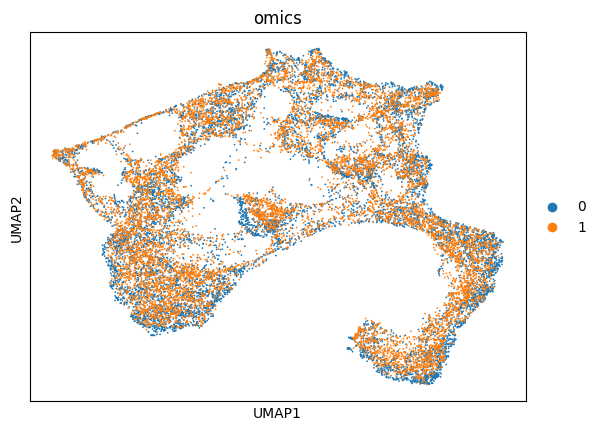

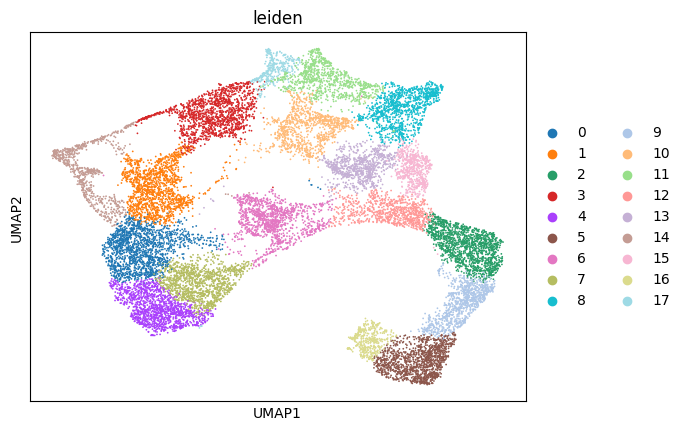

In [306]:
sc.pl.umap(combined, color="omics")
sc.pl.umap(combined, color="leiden")

In [307]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

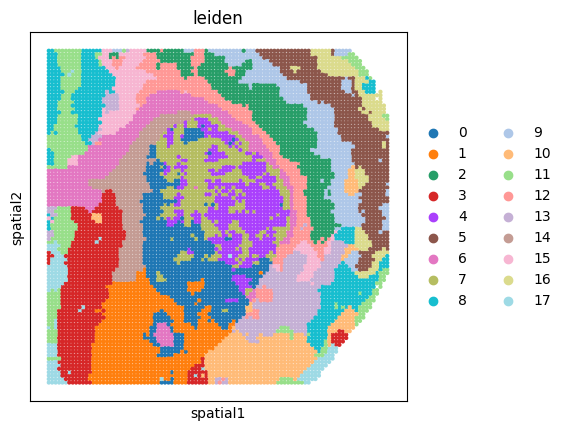

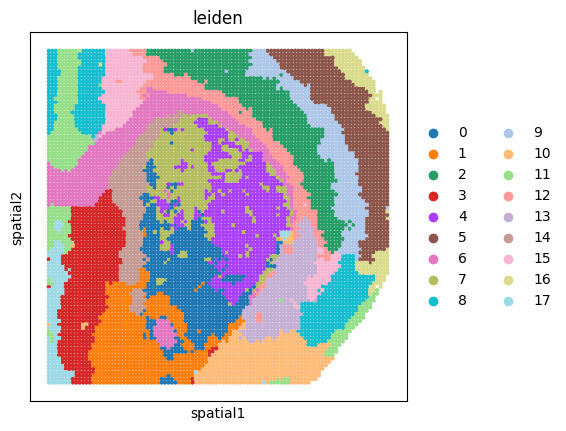

In [308]:
sc.pl.spatial(t_atac, color="leiden",spot_size=34)
sc.pl.spatial(t_rna, color="leiden",spot_size=34)

In [309]:
sw.metrics.foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])

0.030151080533241507

In [310]:
# embed = pd.DataFrame(combined.obsm["SWITCH"])
# embed.to_csv("rep1/SWITCH_embed.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep1/SWITCH_umap.csv")
# cluster = pd.DataFrame(combined.obs["leiden"])
# cluster.to_csv("rep1/SWITCH_cluster.csv")